### Libraries

In [ ]:
import os
import numpy as np
import scipy
import pandas as pd
from functools import reduce
from dotenv import load_dotenv

# Preprocessing
from feature_engine.selection import RecursiveFeatureElimination

# Training
import torch
from pytorch_lightning.callbacks import EarlyStopping

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, mae, mse
from darts.models import NHiTSModel
from darts.utils.likelihood_models import QuantileRegression

# Data processing
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

c:\Users\yukse\Desktop\Yuksel\Yucas\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Dataset

In [3]:
load_dotenv() # Load .env variables

DATASET = os.getenv("DATASET")

# load dataset
dataset = pd.read_csv(DATASET)
print(dataset.head(5))

   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


In [3]:
# Description of dataset
dataset.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [ ]:
# the data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
# Check if there are null or missing values
dataset.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [6]:
# Check Type counts
dataset['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

In [7]:
dataset = dataset.drop(["UDI", "Product ID", "Failure Type"], axis=1)

### Feature Creation

In [ ]:
# Temperature difference between process and air
dataset['temperature_difference'] = dataset['Process temperature [K]'] - dataset['Air temperature [K]']
# Mechanical power using torque and rotational speed
dataset['Mechanical Power [W]'] = np.round((dataset['Torque [Nm]']*dataset['Rotational speed [rpm]']* 2 * np.pi) / 60, 4)

In [9]:
# Statistical Description
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.004930,2.000259,295.3000,298.3000,300.10000,301.5000,304.500
Process temperature [K],10000.0,310.005560,1.483734,305.7000,308.8000,310.10000,311.1000,313.800
Rotational speed [rpm],10000.0,1538.776100,179.284096,1168.0000,1423.0000,1503.00000,1612.0000,2886.000
Torque [Nm],10000.0,39.986910,9.968934,3.8000,33.2000,40.10000,46.8000,76.600
Tool wear [min],10000.0,107.951000,63.654147,0.0000,53.0000,108.00000,162.0000,253.000
Target,10000.0,0.033900,0.180981,0.0000,0.0000,0.00000,0.0000,1.000
temperature_difference,10000.0,10.000630,1.001094,7.6000,9.3000,9.80000,11.0000,12.100
Mechanical Power [W],10000.0,6279.744953,1067.418295,1148.4406,5561.1845,6271.02735,7003.0027,10469.923


In [12]:
dataset.head(20)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,temperature_difference,Mechanical Power [W]
0,M,298.1,308.6,1551,42.8,0,0,10.5,6951.5906
1,L,298.2,308.7,1408,46.3,3,0,10.5,6826.7227
2,L,298.1,308.5,1498,49.4,5,0,10.4,7749.3875
3,L,298.2,308.6,1433,39.5,7,0,10.4,5927.5047
4,L,298.2,308.7,1408,40.0,9,0,10.5,5897.8166
5,M,298.1,308.6,1425,41.9,11,0,10.5,6252.5548
6,L,298.1,308.6,1558,42.4,14,0,10.5,6917.7032
7,L,298.1,308.6,1527,40.2,16,0,10.5,6428.2641
8,M,298.3,308.7,1667,28.6,18,0,10.4,4992.6400
9,M,298.5,309.0,1741,28.0,21,0,10.5,5104.8786


### Data Analysis

C:\Users\yukse\AppData\Local\Temp\ipykernel_14812\1800772357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Type', data=dataset, palette='magma')


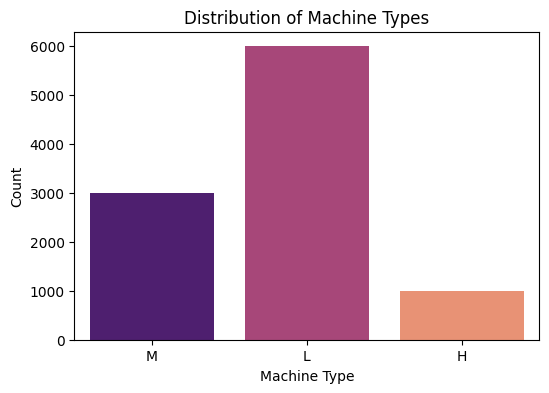

In [14]:
# Plotting the Distribution of Machine Types
plt.figure(figsize=(6,4))
sns.countplot(x='Type', data=dataset, palette='magma')
plt.title('Distribution of Machine Types')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.show()

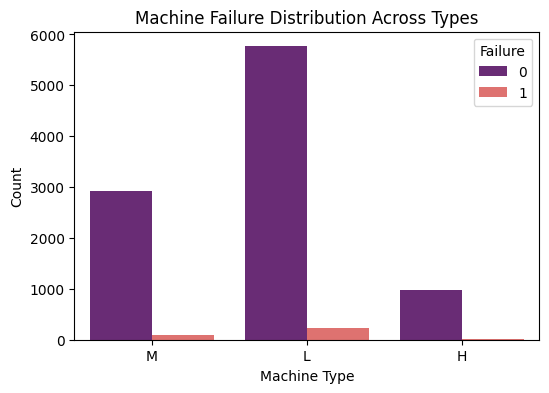

In [16]:
# Visualize Failure Distribution Across Product Types
plt.figure(figsize=(6,4))
sns.countplot(x='Type', hue='Target', data=dataset, palette='magma')
plt.title('Machine Failure Distribution Across Types')
plt.xlabel('Machine Type')
plt.ylabel('Count')
plt.legend(title='Failure')
plt.show()

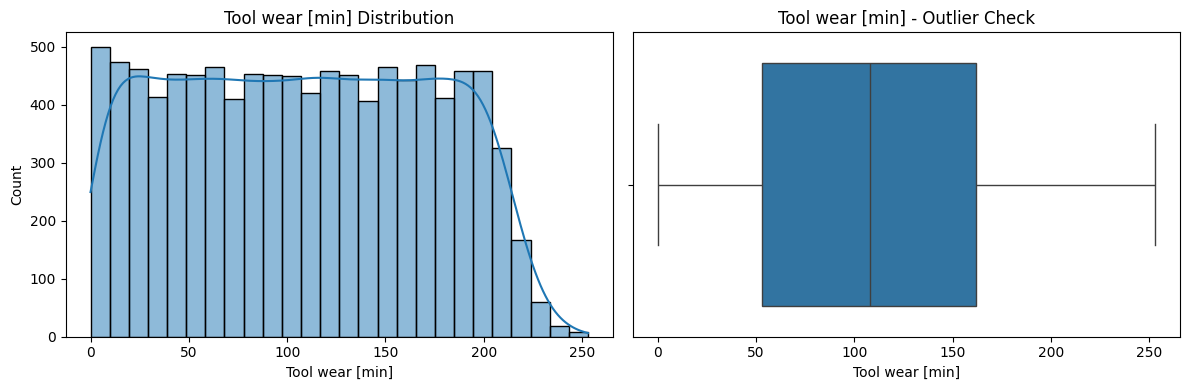

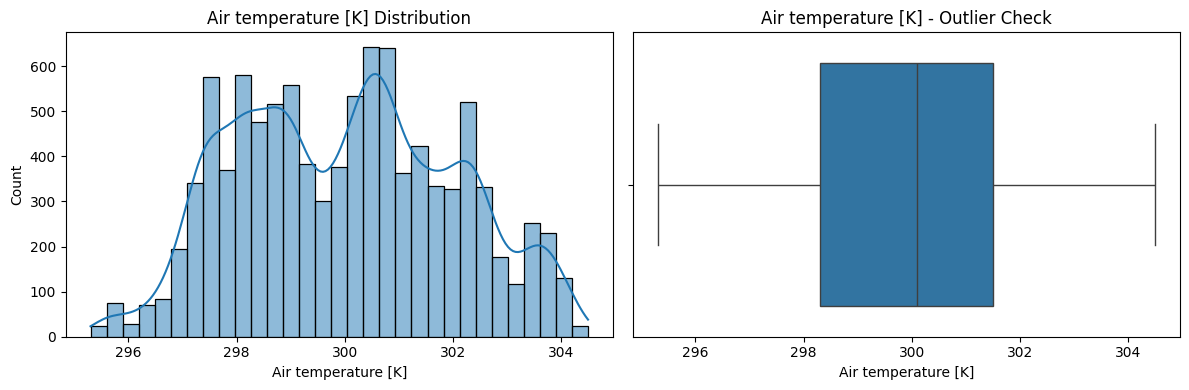

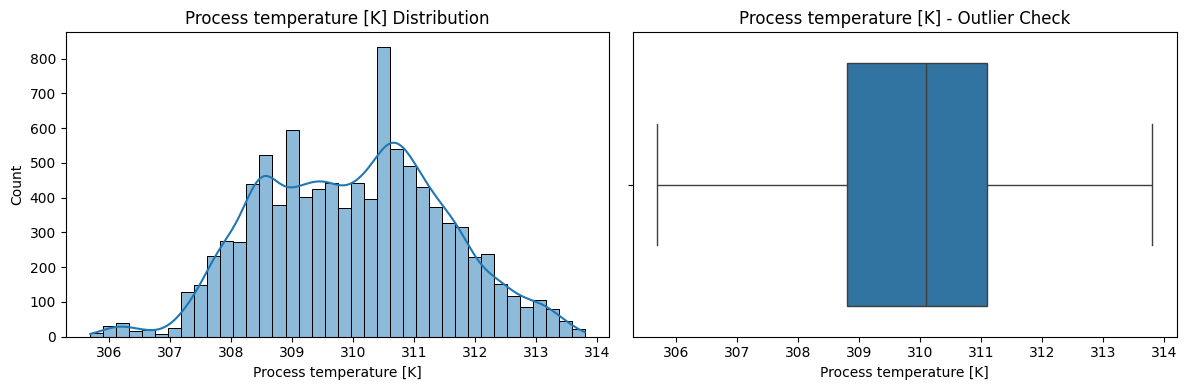

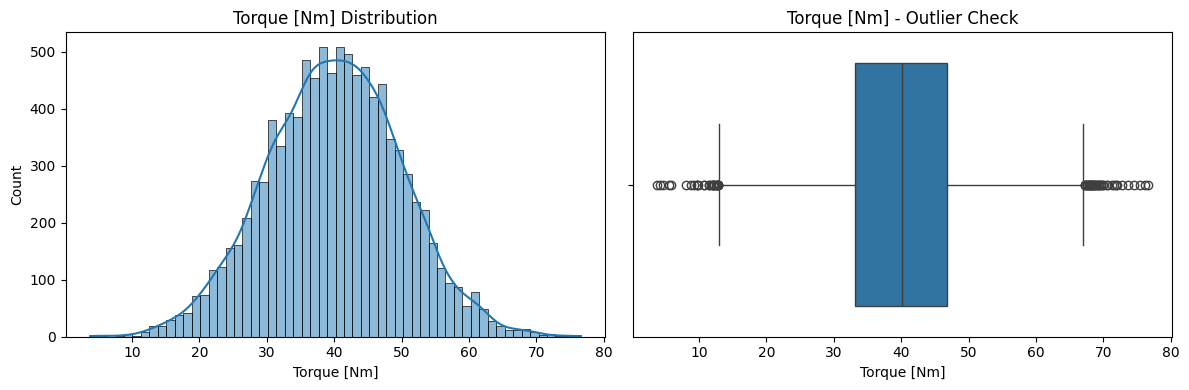

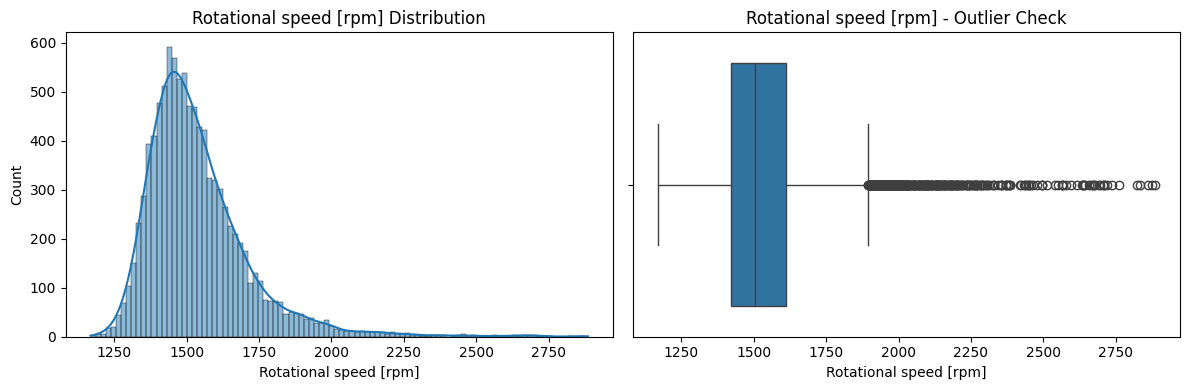

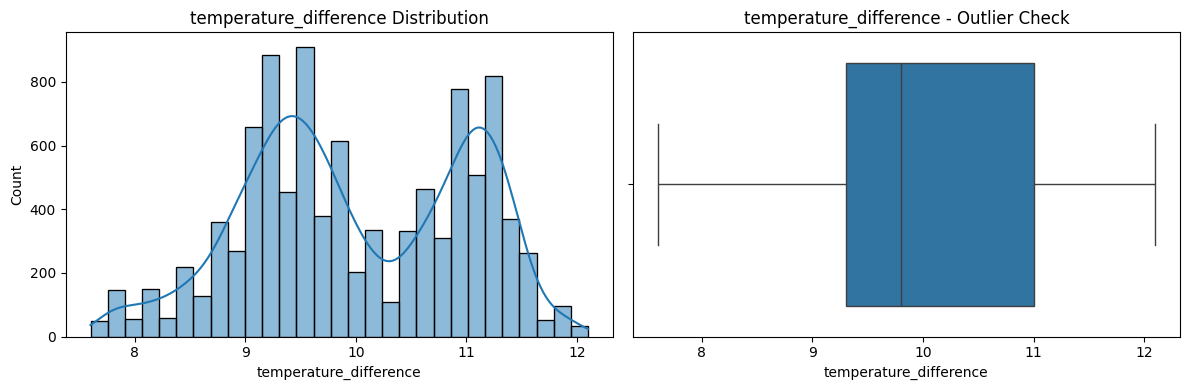

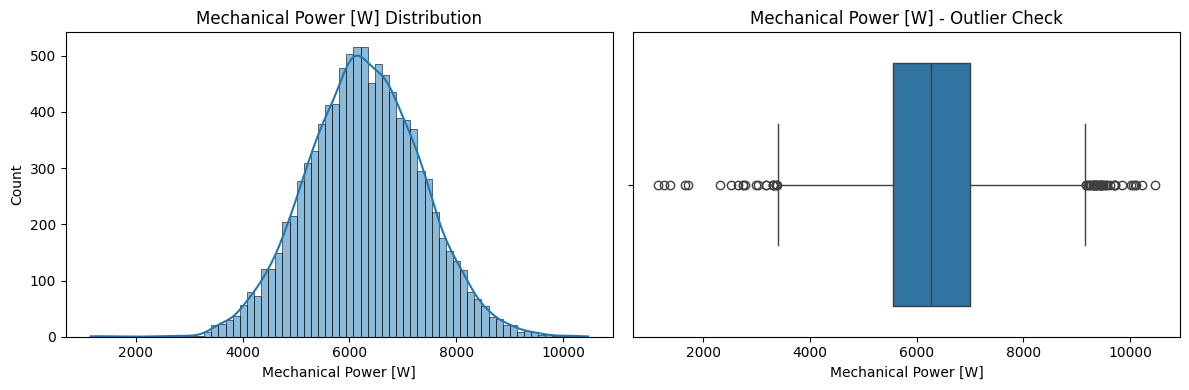

In [17]:
# Plot Feature Distributions to Observe Patterns or Anomalies
cols = ['Tool wear [min]', 'Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]', 
        'Rotational speed [rpm]', 'temperature_difference', 'Mechanical Power [W]']

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

    # Histogram with KDE
    sns.histplot(data=dataset, x=col, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} Distribution")

    # Boxplot
    sns.boxplot(data=dataset, x=col, ax=axes[1])
    axes[1].set_title(f"{col} - Outlier Check")

    plt.tight_layout()
    plt.show()

#### Observations from the Plots:

Mechanical Power [W]: 
- Mechanical Power is roughly unimodal and bell-shaped, with the Kernel Density Estimate (KDE) curve suggesting it approximates a normal distribution, though there might be very slight skewness. 
- The majority of the power readings are concentrated in the center of the distribution, roughly between 4000 W and 8000 W.
- The peak (most frequent values) seems to be around 6000-6500 W.

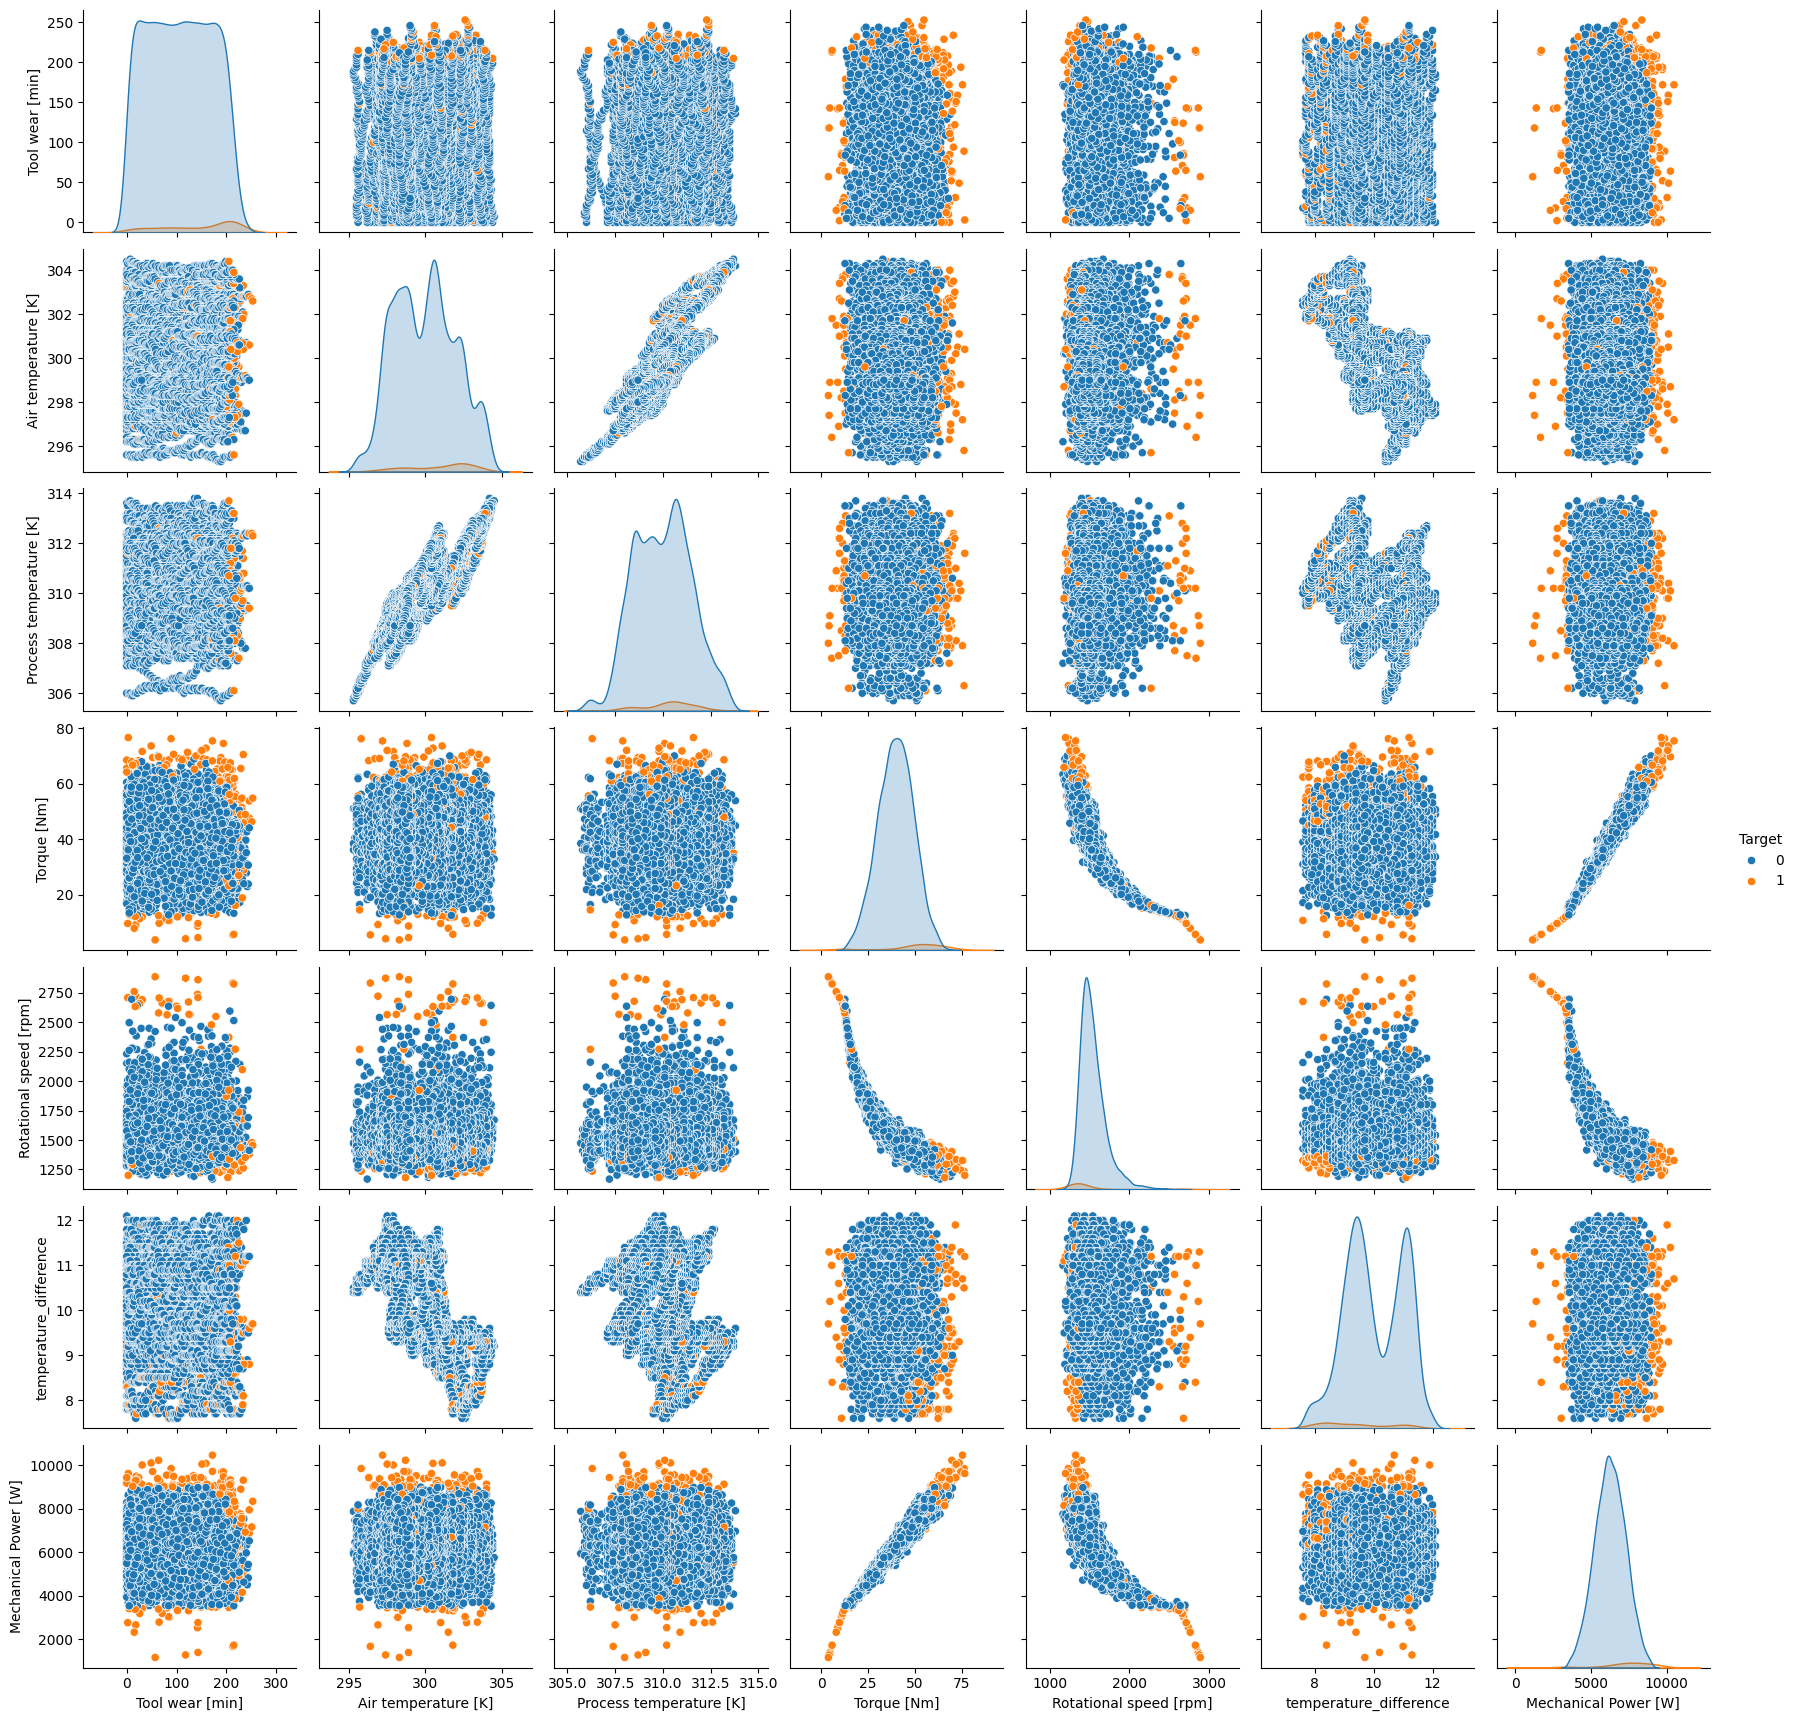

In [18]:
# Shows interaction between features colored by failure
sns.pairplot(dataset[['Tool wear [min]', 'Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]', 'Rotational speed [rpm]', 'temperature_difference','Mechanical Power [W]', 'Target']], hue='Target')
plt.show()

#### Key Insights for Predicting Machine Failure (from Pairplot Analysis)

This analysis of feature interactions, colored by machine failure status (`Target`), reveals several critical patterns that inform our predictive modeling strategy:

##### 1. Strongest Individual Predictors (Extremes Indicate Risk)

The following features show a higher likelihood of failure when their values are at the extremes (either very low or very high) compared to their typical operating ranges:

*   **Torque [Nm]:** Failures are notably more frequent at both **very low and very high torque** values.
*   **Rotational Speed [rpm]:** Similar to torque, failures concentrate at **very low and very high rotational speeds**.
*   **Mechanical Power [W]:** Being derived from torque and speed, this feature also shows increased failures at **both very low and very high power outputs**.
*   **Tool Wear [min]:** While failures can occur at various levels, **higher tool wear** generally correlates with an increased risk of failure.

##### 2. Crucial Feature Interactions Driving Failures

Certain combinations of feature values are particularly indicative of failure:

*   **Torque & Rotational Speed:** This is a highly discriminative interaction.
    *   Operating outside a central "sweet spot" (e.g., **high torque & low speed**, **low torque & high speed**, or **high torque & high speed**) is strongly associated with failure.
*   **Tool Wear with Operating Parameters:**
    *   The risk associated with **high tool wear** is amplified when combined with extreme operating conditions (e.g., high tool wear AND high torque; high tool wear AND low rotational speed).
*   **Temperature with Operating Parameters:**
    *   Extreme temperatures (**Process Temperature**, or a very large/small **Temperature Difference**) coupled with extreme **Torque, Rotational Speed, or Mechanical Power** also indicate a heightened failure risk. For instance, a high temperature difference alongside high torque appears to be a notable failure scenario.

##### 3. Non-Linear Relationships are Prevalent

*   Many features exhibit **non-linear (e.g., U-shaped) relationships** with the likelihood of failure.
*   This suggests that models capable of capturing these complex patterns (e.g., tree-based ensembles like Random Forest/XGBoost, Neural Networks) are likely to outperform simpler linear models.

##### 4. Potential for Feature Engineering

*   While some interactions are visually apparent, explicitly creating **interaction terms** (e.g., `Torque * Rotational_Speed`) or **polynomial features** could further enhance model performance by making these relationships more explicit for certain algorithms.
*   Exploring other **ratios or differences** between related features might also uncover valuable predictive signals.

##### 5. Confirmed Data Imbalance

*   The visualizations clearly show a significantly higher number of non-failure instances (`Target = 0`) compared to failure instances (`Target = 1`).
*   This **class imbalance** is a critical consideration and will need to be addressed during the model training phase (e.g., through techniques like SMOTE, class weighting, or appropriate evaluation metrics).

These insights will guide feature selection, feature engineering choices, the selection of appropriate machine learning models, and the strategies for handling data imbalances to build an effective predictive maintenance solution.

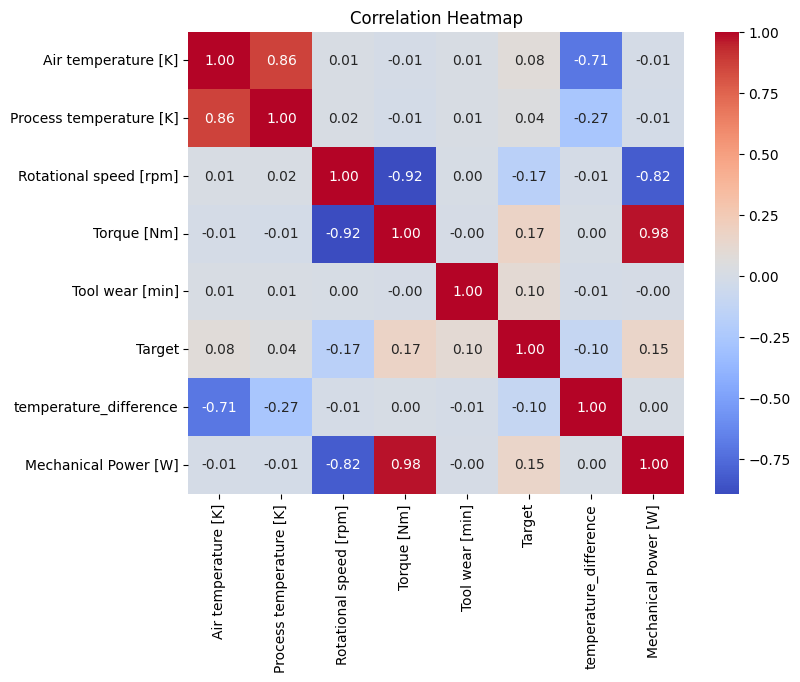

In [19]:
# Check the correlation between the data
plt.figure(figsize=(8,6))
plt.rcParams["axes.grid"] = False
pearson_corr_matrix = dataset.corr(method='spearman', numeric_only=True)
sns.heatmap(pearson_corr_matrix, annot=True, robust=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### Correlations with the 'Target' Variable (Failure):

* **Torque [Nm] (0.17):** Shows a weak positive linear correlation with 'Target'. This suggests that as torque increases, there's a slight tendency for failures to increase. However, the pairplot showed a U-shaped relationship, so this linear correlation doesn't capture the full picture (failures also at low torque).

* **Rotational speed [rpm] (-0.17):** Shows a weak negative linear correlation with 'Target'. This suggests that as rotational speed increases, there's a slight tendency for failures to decrease. Again, the pairplot showed failures at both low and high speeds, so this linear measure is only part of the story.

* **Tool wear [min] (0.10):** A very weak positive linear correlation with 'Target'. Suggests a slight increase in failure probability with increased tool wear.

* **Mechanical Power [W] (0.15):** A weak positive linear correlation with 'Target'. Similar to torque.

* **Air temperature [K] (0.08):** Very weak positive linear correlation.

* **Process temperature [K] (0.04):** Extremely weak positive linear correlation.

* **temperature_difference (-0.10):** A very weak negative linear correlation.

### Encoding Columns

In [21]:
# Label encoding categorical variables (column- Type)
dataset['Type'] = LabelEncoder().fit_transform(dataset['Type'])
dataset.head(5)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,temperature_difference,Mechanical Power [W]
0,2,298.1,308.6,1551,42.8,0,0,10.5,6951.5906
1,1,298.2,308.7,1408,46.3,3,0,10.5,6826.7227
2,1,298.1,308.5,1498,49.4,5,0,10.4,7749.3875
3,1,298.2,308.6,1433,39.5,7,0,10.4,5927.5047
4,1,298.2,308.7,1408,40.0,9,0,10.5,5897.8166


### Feature Elimination

In [24]:
# initialize linear regresion estimator
rfr_model = RandomForestRegressor()

# initialize feature selector
# neg_mean_squared_error
rfe = RecursiveFeatureElimination(estimator=rfr_model, scoring="r2", cv=3)

# Prepare dataset
X = dataset.drop(["Target"], axis=1)
y = dataset["Target"]

x_transformed = rfe.fit_transform(X, y)
print(x_transformed.head(5))

   Type  Torque [Nm]  Tool wear [min]  temperature_difference  \
0     2         42.8                0                    10.5   
1     1         46.3                3                    10.5   
2     1         49.4                5                    10.4   
3     1         39.5                7                    10.4   
4     1         40.0                9                    10.5   

   Mechanical Power [W]  
0             6951.5906  
1             6826.7227  
2             7749.3875  
3             5927.5047  
4             5897.8166  


### Dataset Preparation

In [36]:
# Define which columns are your main features and which are covariates
main_feature_cols = ['Torque [Nm]', 'Tool wear [min]', 'temperature_difference', 'Mechanical Power [W]']
covariate_cols = ['Type']

# Convert DataFrame into Darts TimeSeries format
main_ts = TimeSeries.from_dataframe(x_transformed, value_cols=main_feature_cols)
covariates_ts = TimeSeries.from_dataframe(x_transformed, value_cols=covariate_cols)

# The 'Target' column (0 or 1) is what we want to predict.
target_ts = TimeSeries.from_series(y) # y is dataset["Target"]

In [37]:
print("--- Original TimeSeries (first 5 entries) ---")
print("Main TS:")
print(main_ts.to_dataframe().head())
print("\nCovariates TS:")
print(covariates_ts.to_dataframe().head())

--- Original TimeSeries (first 5 entries) ---
Main TS:
component  Torque [Nm]  Tool wear [min]  temperature_difference  \
time                                                              
0                 42.8              0.0                    10.5   
1                 46.3              3.0                    10.5   
2                 49.4              5.0                    10.4   
3                 39.5              7.0                    10.4   
4                 40.0              9.0                    10.5   

component  Mechanical Power [W]  
time                             
0                     6951.5906  
1                     6826.7227  
2                     7749.3875  
3                     5927.5047  
4                     5897.8166  

Covariates TS:
component  Type
time           
0           2.0
1           1.0
2           1.0
3           1.0
4           1.0


In [38]:
# Split dataset
split_fraction = 0.8

train_main_ts, test_main_ts = main_ts.split_after(split_fraction)
train_target_ts, test_target_ts = target_ts.split_after(split_fraction)

if covariates_ts:
    train_covariates_ts, test_covariates_ts = covariates_ts.split_after(split_fraction)
else:
    train_covariates_ts, test_covariates_ts = None, None

print(f"\n--- Data Splitting ---")
print(f"Training main series length: {len(train_main_ts)}")
print(f"Test main series length: {len(test_main_ts)}")
print(f"Training covariates series length: {len(train_covariates_ts)}")
print(f"Test covariates series length: {len(test_covariates_ts)}")


--- Data Splitting ---
Training main series length: 8000
Test main series length: 2000
Training covariates series length: 8000
Test covariates series length: 2000


In [39]:
# Scale the data
scaler = Scaler(StandardScaler())

# Fit the scaler only on the training part
scaler.fit(train_main_ts)

Scaler

In [40]:
# Transform both the training and test data
train_main_ts_scaled = scaler.transform(train_main_ts)
test_main_ts_scaled = scaler.transform(test_main_ts)

In [41]:
# Prepare past_covariates for Training
if train_covariates_ts:
    train_past_covariates = train_main_ts_scaled.stack(train_covariates_ts)
else: # If no covariates
    train_past_covariates = train_main_ts_scaled

In [42]:
# Prepare full_past_covariates for Prediction
full_main_ts_scaled = scaler.transform(main_ts)

In [43]:
# Stack with the entire original covariates_ts (if it exists).
if covariates_ts:
    full_past_covariates = full_main_ts_scaled.stack(covariates_ts)
else:
    full_past_covariates = full_main_ts_scaled

In [44]:
print("--- Data Preparation for N-HiTS Complete ---")
print(f"Training Target TS length: {len(train_target_ts)}")
print(f"Training Past Covariates components: {train_past_covariates.n_components}, length: {len(train_past_covariates)}")
if full_past_covariates:
    print(f"Full Past Covariates components: {full_past_covariates.n_components}, length: {len(full_past_covariates)}")

--- Data Preparation for N-HiTS Complete ---
Training Target TS length: 8000
Training Past Covariates components: 5, length: 8000
Full Past Covariates components: 5, length: 10000


### Training

In [49]:
# Train N-HiTS model
input_chunk_length = 100  # Number of past time steps the model sees. Adjust based on data.
output_chunk_length = 10 # Predicting 1 step ahead (failure at the next step).
n_epochs = 200           # Number of training epochs. Increase for real datasets.
num_stacks = 3
num_layers = 2
layer_widths = 128
num_blocks= 1
dropout = 0.1
lr = 1e-4
activation = "ReLU"
optimizer_class = torch.optim.Adam

# reproducibility
torch.manual_seed(42)

In [50]:
# Ensure training target series is long enough
if len(train_target_ts) < input_chunk_length + output_chunk_length:
    new_input_chunk_length = max(1, len(train_target_ts) - output_chunk_length -1)
    print(f"Warning: Training target series is very short ({len(train_target_ts)}).")
    print(f"Reducing input_chunk_length from {input_chunk_length} to {new_input_chunk_length}.")
    input_chunk_length = new_input_chunk_length
    if input_chunk_length <= 0 : # Changed from == 0 to <=0 for robustness
        raise ValueError(f"Training target series (length {len(train_target_ts)}) is too short for "
                         f"input_chunk_length {input_chunk_length} and output_chunk_length {output_chunk_length}. "
                         "Need more data or smaller chunk lengths.")

In [ ]:
# Model parameter setup
early_stopper = EarlyStopping(monitor="train_loss", min_delta=0.001, patience=15, verbose=True, mode="min")
callbacks = [early_stopper]

pl_trainer_kwargs = {
    "accelerator": "cuda",
    "callbacks": callbacks,
    "enable_progress_bar": True
}


# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {"gamma": 0.999}

# build the TCN model
model = NHiTSModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    batch_size=32,
    num_stacks = num_stacks,
    num_blocks = num_blocks,
    num_layers = num_layers,
    layer_widths = layer_widths,
    activation = activation,
    n_epochs=n_epochs,
    nr_epochs_val_period=1,
    dropout=dropout,
    optimizer_kwargs={"lr": lr},
    likelihood=QuantileRegression(),
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="NHits",
    force_reset=True,
    save_checkpoints=True,
)

model.fit(series=train_target_ts, past_covariates=train_past_covariates)

model = NHiTSModel.load_from_checkpoint("NHits", best=True)
print("\n--- N-HiTS Model Training Complete ---")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 494 K  | train
-------------------------------------------------------------
417 K     Trainable params
77.4 K    Non-trainable params
494 K     Total params
1.978     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 247/247 [00:02<00:00, 117.15it/s, train_loss=0.323]

Metric train_loss improved. New best score: 0.323


Epoch 1:   8%|▊         | 19/247 [00:00<00:01, 134.49it/s, train_loss=0.469] 

c:\Users\yukse\Desktop\Yuksel\Yucas\NLP\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


Epoch 1: 100%|██████████| 247/247 [00:01<00:00, 133.64it/s, train_loss=0.200]

Metric train_loss improved by 0.123 >= min_delta = 0.001. New best score: 0.200


Epoch 4: 100%|██████████| 247/247 [00:01<00:00, 134.79it/s, train_loss=0.189] 

Metric train_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.189


Epoch 5: 100%|██████████| 247/247 [00:01<00:00, 131.87it/s, train_loss=0.184] 

Metric train_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.184


Epoch 12: 100%|██████████| 247/247 [00:01<00:00, 128.92it/s, train_loss=0.176]

Metric train_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.176


Epoch 22: 100%|██████████| 247/247 [00:01<00:00, 127.52it/s, train_loss=0.131] 

Metric train_loss improved by 0.046 >= min_delta = 0.001. New best score: 0.131


Epoch 27: 100%|██████████| 247/247 [00:01<00:00, 123.92it/s, train_loss=0.049] 

Metric train_loss improved by 0.081 >= min_delta = 0.001. New best score: 0.049


Epoch 42: 100%|██████████| 247/247 [00:02<00:00, 116.03it/s, train_loss=0.760] 

Monitored metric train_loss did not improve in the last 15 records. Best score: 0.049. Signaling Trainer to stop.


Epoch 42: 100%|██████████| 247/247 [00:02<00:00, 114.07it/s, train_loss=0.760]

--- N-HiTS Model Training Complete ---


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Making Predictions on Test Set ---
Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.94it/s]

Raw Continuous Predictions (first 5 values):
component    Target
time               
8000      -0.000012
8001      -0.000004
8002       0.000159
8003       0.000009
8004       0.000020
8005      -0.000096
8006      -0.000052
8007      -0.000381
8008      -0.000019
8009      -0.000342

--- Evaluation (Threshold = 0.5) ---
   Actual  Predicted_Label  Predicted_Continuous
0     0.0                0             -0.000012
1     0.0                0             -0.000004
2     0.0                0              0.000159
3     0.0                0              0.000009
4     0.0                0              0.000020
5     0.0                0             -0.000096
6     0.0                0             -0.000052
7     0.0                0             -0.000381
8     0.0                0             -0.000019
9     0.0                0             -0.000342

Classification Report:
  

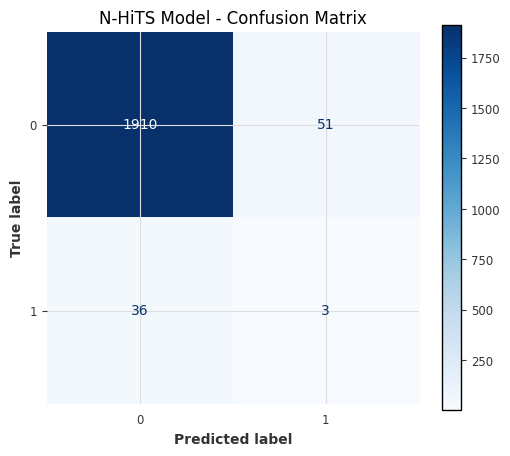

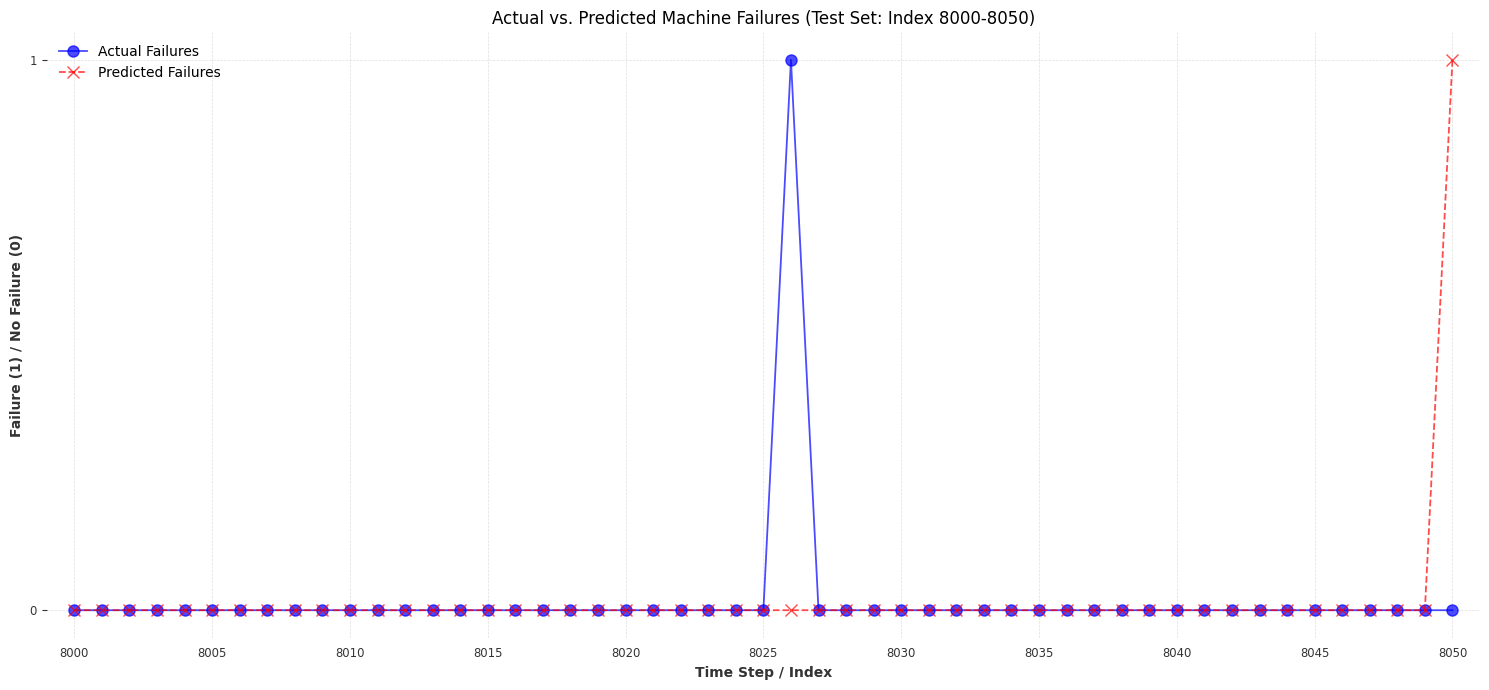

In [60]:
# --- Making Predictions on the Test Set ---
if len(test_target_ts) > 0:
    print("\n--- Making Predictions on Test Set ---")
    try:
        # `series` = historical target data (train_target_ts) to condition the forecast start.
        # `past_covariates` = all available past covariates (full_past_covariates).
        # Darts will select the appropriate slice of `full_past_covariates`.
        predictions_nhits = model.predict(
            n=len(test_target_ts),
            series=train_target_ts,
            past_covariates=full_past_covariates
        )

        print("\nRaw Continuous Predictions (first 5 values):")
        print(predictions_nhits.to_dataframe().head(10))

        # --- Evaluation (for binary target) ---
        actual_values = test_target_ts.values(copy=True).flatten()
        predicted_continuous_values = predictions_nhits.values(copy=True).flatten()

        threshold = 0.5 # Common threshold for binary classification
        predicted_labels = (predicted_continuous_values >= threshold).astype(int)

        # Ensure lengths match for comparison (in case of any off-by-one issues due to prediction mechanics)
        min_len = min(len(actual_values), len(predicted_labels))
        actual_labels_eval = actual_values[:min_len]
        predicted_labels_eval = predicted_labels[:min_len]

        if min_len > 0:
            print(f"\n--- Evaluation (Threshold = {threshold}) ---")
            comparison_df = pd.DataFrame({
                'Actual': actual_labels_eval,
                'Predicted_Label': predicted_labels_eval,
                'Predicted_Continuous': predicted_continuous_values[:min_len]
            })
            print(comparison_df.head(10))

            
            print("\nClassification Report:")
            print(classification_report(actual_labels_eval, predicted_labels_eval, zero_division=0))
            print(f"Accuracy: {accuracy_score(actual_labels_eval, predicted_labels_eval):.4f}")
            try:
                roc_auc = roc_auc_score(actual_labels_eval, predicted_continuous_values[:min_len])
                print(f"ROC AUC Score: {roc_auc:.4f}")
            except ValueError as e:
                print(f"Could not calculate ROC AUC Score: {e}") #

            print("\nConfusion Matrix:")
            # Calculate the confusion matrix
            cm = confusion_matrix(actual_labels_eval, predicted_labels_eval)
            print("\nConfusion Matrix (raw array):")
            print(cm)

            # --- Plotting the Confusion Matrix as a Heatmap ---
            # Method 1: Using scikit-learn's ConfusionMatrixDisplay (Recommended)
            display_labels = [0, 1] # Assuming your labels are 0 (No Failure) and 1 (Failure)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

            fig, ax = plt.subplots(figsize=(6, 5)) # Adjust figure size as needed
            disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d') # 'd' for integer format
            ax.set_title('N-HiTS Model - Confusion Matrix')
            # disp.ax_.set_title('N-HiTS Model - Confusion Matrix') # Alternative way to set title if needed
            plt.show()


             # --- Plotting Actual vs. Predicted Labels ---
            # Define the desired x-axis range for display
            x_min_display = 8000
            x_max_display = 8050 # Show up to index 8050

            plt.figure(figsize=(15, 7)) # Adjusted figure size for better zoomed view

            # Get the time index from the test_target_ts for the x-axis
            # This index corresponds to the original DataFrame's index for the test portion
            time_index_full_test = test_target_ts.time_index # This is a pandas Index

            # Ensure actual_labels_eval and predicted_labels_eval are numpy arrays for boolean indexing
            actual_labels_np = np.array(actual_labels_eval)
            predicted_labels_np = np.array(predicted_labels_eval)
            time_index_np = time_index_full_test[:min_len].to_numpy() # Convert relevant part of index to numpy

            # Create a mask for the desired display range
            # This assumes time_index_np contains the global indices you want to filter by
            display_mask = (time_index_np >= x_min_display) & (time_index_np <= x_max_display)

            # Filter the data using the mask
            time_index_display = time_index_np[display_mask]
            actual_labels_display = actual_labels_np[display_mask]
            predicted_labels_display = predicted_labels_np[display_mask]

            if len(time_index_display) > 0: # Check if there's any data in the selected range
                plt.plot(time_index_display, actual_labels_display, label='Actual Failures', marker='o', linestyle='-', color='blue', alpha=0.7, markersize=8)
                plt.plot(time_index_display, predicted_labels_display, label='Predicted Failures', marker='x', linestyle='--', color='red', alpha=0.7, markersize=8)

                plt.title(f'Actual vs. Predicted Machine Failures (Test Set: Index {x_min_display}-{x_max_display})')
                plt.xlabel('Time Step / Index')
                plt.ylabel('Failure (1) / No Failure (0)')
                plt.yticks([0, 1])
                plt.xticks(np.arange(min(time_index_display), max(time_index_display)+1, step=max(1, (max(time_index_display)-min(time_index_display))//10))) # Adjust x-ticks for better readability in zoom
                plt.xlim(x_min_display -1, x_max_display +1) # Set x-axis limits to focus on the range, with a little padding
                plt.legend()
                plt.grid(True, which='both', linestyle='--', linewidth=0.5)
                plt.tight_layout()
                plt.show()
            else:
                print(f"No data points found in the specified display range ({x_min_display}-{x_max_display}) within the evaluated test set.")

        else:
            print("Not enough data in the test set for evaluation after prediction, or lengths mismatch.")

    except Exception as e:
        print(f"Error during prediction or evaluation: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\nTest set (test_target_ts) is empty. Skipping prediction and evaluation.")